# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import numpy as np
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "./"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [6]:
df_train_features["lobby_type"].value_counts()

7    21607
0    10091
Name: lobby_type, dtype: int64

In [7]:
df_train_features["game_mode"].value_counts()

22    25324
4      2877
23     2079
3       948
2       315
5       148
12        5
16        2
Name: game_mode, dtype: int64

### Add OneHotEncoding for hero_id, game_mode and lobby_type features 


In [8]:
df_to_modify = pd.concat([df_train_features, df_test_features])

In [9]:
df_to_modify.shape

(39675, 245)

In [10]:
ohe_columns_to_transform = []
for column in df_to_modify.columns:
    if column.endswith('id'):
        ohe_columns_to_transform.append(column)

In [11]:
ohe = OneHotEncoder()
ohe.fit(df_to_modify[ohe_columns_to_transform])

OneHotEncoder()

In [12]:
df_to_modify_new = pd.DataFrame(ohe.transform(df_to_modify[ohe_columns_to_transform]).toarray()).set_index(df_to_modify.index)

In [13]:
new_columns = []
for column in df_to_modify_new.columns:
    new_columns.append('player_id_' + str(column))
    
df_to_modify_new.columns = new_columns

In [14]:
df_to_modify_new = df_to_modify.drop(ohe_columns_to_transform, axis=1).join(df_to_modify_new)

In [15]:
ohe2 = OneHotEncoder()
ohe2.fit(df_to_modify_new["lobby_type"].to_frame())

df_to_modify_new2 = pd.DataFrame(ohe2.transform(df_to_modify_new["lobby_type"].to_frame()).toarray()).set_index(df_to_modify_new.index)

new_columns2 = []
for column in df_to_modify_new2.columns:
    new_columns2.append('lobby_type_' + str(column))
    
df_to_modify_new2.columns = new_columns2
df_to_modify_new = df_to_modify_new.drop("lobby_type", axis=1).join(df_to_modify_new2)

In [16]:
ohe3 = OneHotEncoder()
ohe3.fit(df_to_modify_new["game_mode"].to_frame())

df_to_modify_new2 = pd.DataFrame(ohe3.transform(df_to_modify_new["game_mode"].to_frame()).toarray()).set_index(df_to_modify_new.index)

new_columns3 = []
for column in df_to_modify_new2.columns:
    new_columns3.append('game_mode_' + str(column))
    
df_to_modify_new2.columns = new_columns3
df_to_modify_new = df_to_modify_new.drop("game_mode", axis=1).join(df_to_modify_new2)

In [17]:
df_to_modify_new

,game_time,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,...,lobby_type_0,lobby_type_1,game_mode_0,game_mode_1,game_mode_2,game_mode_3,game_mode_4,game_mode_5,game_mode_6,game_mode_7
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,3,10,7,2,0,7,5257,52,3937,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6db558535151ea18ca70a6892197db41,21,0,0,0,0,0,0,176,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19c39fe2af2b547e48708ca005c6ae74,160,0,0,0,0,0,1,403,0,359,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,1,0,0,3,3,5,3085,1,2828,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,2,2,3,1,2,9,3516,40,3964,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,1,0,2,0,0,1,2621,16,2794,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
06e2b42495855647830ccc6d466f913c,2561,17,7,2,9,1,6,7223,46,9094,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,8,23,1,9,9,0,6283,13,7847,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Add KDA score from kills, death and assists

In [18]:
kills_columns = []
deaths_columns = []
assists_columns = []

for column in df_to_modify_new.columns:
    if column.endswith('kills'):
        kills_columns.append(column)
    elif column.endswith('deaths'):
        deaths_columns.append(column)
    elif column.endswith('assists'):
        assists_columns.append(column)

In [19]:
players_prefixes = list(map(lambda x: x[:2], kills_columns))

for i in range(len(kills_columns)):
    
    index_list_with_zero_deaths = df_to_modify_new.loc[(df_to_modify_new[deaths_columns[i]] == 0)].index
    
    df_to_modify_new[(players_prefixes[i] + "_KDA")] =\
    df_to_modify_new[kills_columns[i]] + df_to_modify_new[assists_columns[i]] /\
    df_to_modify_new[deaths_columns[i]]
    
    df_to_modify_new.loc[index_list_with_zero_deaths, (players_prefixes[i] + "_KDA")] =\
    df_to_modify_new.loc[index_list_with_zero_deaths, kills_columns[i]] +\
    df_to_modify_new.loc[index_list_with_zero_deaths, assists_columns[i]] /\
    (df_to_modify_new.loc[index_list_with_zero_deaths, deaths_columns[i]] + 1)

In [20]:
df_to_modify_new

,game_time,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,...,r1_KDA,r2_KDA,r3_KDA,r4_KDA,r5_KDA,d1_KDA,d2_KDA,d3_KDA,d4_KDA,d5_KDA
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,3,10,7,2,0,7,5257,52,3937,...,7.000000,5.000000,5.000000,7.000000,6.000000,1.000000,1.000000,1.333333,0.666667,0.000000
6db558535151ea18ca70a6892197db41,21,0,0,0,0,0,0,176,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,0,0,0,0,0,1,403,0,359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,1,0,0,3,3,5,3085,1,2828,...,1.000000,3.200000,2.000000,4.000000,4.000000,3.250000,4.000000,4.500000,4.666667,3.000000
156c88bff4e9c4668b0f53df3d870f1b,582,2,2,3,1,2,9,3516,40,3964,...,5.000000,0.500000,4.000000,1.000000,0.000000,6.000000,2.000000,5.000000,2.000000,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,1,0,2,0,0,1,2621,16,2794,...,2.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
06e2b42495855647830ccc6d466f913c,2561,17,7,2,9,1,6,7223,46,9094,...,2.111111,24.166667,7.647059,2.777778,11.428571,11.333333,10.909091,11.444444,10.500000,7.857143
defd0caeed6ea83d7d5fbdec013fe7d1,1783,8,23,1,9,9,0,6283,13,7847,...,2.000000,3.142857,5.142857,8.666667,4.833333,7.571429,19.000000,9.500000,11.200000,5.250000


### Add common gold and xp for the team

In [21]:
gold_columns = []
xp_columns = []
for column in df_to_modify_new.columns:
    if column.endswith('gold'):
        gold_columns.append(column)
    elif column.endswith('xp'):
        xp_columns.append(column)

In [22]:
df_to_modify_new["r_team_gold"] = df_to_modify_new[gold_columns[:5]].sum(axis=1)
df_to_modify_new["d_team_gold"] = df_to_modify_new[gold_columns[5:]].sum(axis=1)
df_to_modify_new["r_team_xp"] = df_to_modify_new[xp_columns[:5]].sum(axis=1)
df_to_modify_new["d_team_xp"] = df_to_modify_new[xp_columns[5:]].sum(axis=1)

In [23]:
list_col = gold_columns + ["r_team_gold"] + ["d_team_gold"]
df_to_modify_new[list_col]

,r1_gold,r2_gold,r3_gold,r4_gold,r5_gold,d1_gold,d2_gold,d3_gold,d4_gold,d5_gold,r_team_gold,d_team_gold
match_id_hash,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,5257,3394,2212,4206,3103,2823,2466,3624,2808,1423,18172,13144
6db558535151ea18ca70a6892197db41,176,176,176,176,176,96,96,96,96,96,880,480
19c39fe2af2b547e48708ca005c6ae74,403,541,701,844,458,282,243,424,477,417,2947,1843
c96d629dc0c39f0c616d1949938a6ba6,3085,2985,6350,5204,6026,4295,4182,3760,5821,2761,23650,20819
156c88bff4e9c4668b0f53df3d870f1b,3516,1972,2560,3415,1165,1880,2957,3874,3000,1707,12628,13418
...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,2621,1575,3588,2049,2233,2443,1674,3018,892,1425,12066,9452
06e2b42495855647830ccc6d466f913c,7223,23040,17768,13784,19299,19342,16994,14568,19334,14872,81114,85110
defd0caeed6ea83d7d5fbdec013fe7d1,6283,8838,8530,14815,9864,9371,13071,7937,15226,6033,48330,51638


In [24]:
df_to_modify_new_dropped = df_to_modify_new.drop(gold_columns + xp_columns +
                                                           kills_columns + deaths_columns + 
                                                           assists_columns, axis=1)

In [25]:
df_to_modify_new_dropped

,game_time,objectives_len,chat_len,r1_denies,r1_lh,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,...,r5_KDA,d1_KDA,d2_KDA,d3_KDA,d4_KDA,d5_KDA,r_team_gold,d_team_gold,r_team_xp,d_team_xp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,3,10,7,52,1160,1160,566.93805,8,76,...,6.000000,1.000000,1.000000,1.333333,0.666667,0.000000,18172,13144,17566,12925
6db558535151ea18ca70a6892197db41,21,0,0,0,0,680,680,506.93800,1,118,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,880,480,0,0
19c39fe2af2b547e48708ca005c6ae74,160,0,0,1,0,740,740,290.93777,2,92,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2947,1843,2942,2513
c96d629dc0c39f0c616d1949938a6ba6,1016,1,0,5,1,495,740,816.93830,6,112,...,4.000000,3.250000,4.000000,4.500000,4.666667,3.000000,23650,20819,26116,27341
156c88bff4e9c4668b0f53df3d870f1b,582,2,2,9,40,495,960,530.93800,8,120,...,0.000000,6.000000,2.000000,5.000000,2.000000,3.500000,12628,13418,13044,13598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,1,0,1,16,781,960,648.93810,6,78,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12066,9452,13231,10961
06e2b42495855647830ccc6d466f913c,2561,17,7,6,46,1360,1360,1396.93880,14,72,...,11.428571,11.333333,10.909091,11.444444,10.500000,7.857143,81114,85110,99258,110982
defd0caeed6ea83d7d5fbdec013fe7d1,1783,8,23,0,13,0,1380,710.93820,13,144,...,4.833333,7.571429,19.000000,9.500000,11.200000,5.250000,48330,51638,57556,65289


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [26]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [27]:
X = df_to_modify_new_dropped.iloc[:31698].values
y = df_train_targets["radiant_win"].values.astype("int8")

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [ ]:
%%time
rf_model = RandomForestClassifier(n_estimators=500, max_depth=25, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 2min 8s, sys: 253 ms, total: 2min 8s
Wall time: 1min 9s


In [ ]:
%%time
rf_model = RandomForestClassifier(n_estimators=500, max_depth=25, n_jobs=-1, random_state=SEED)
rf_model.fit(X, y)

CPU times: user 3min 35s, sys: 1 s, total: 3min 36s
Wall time: 2min


#### Сделаем предсказания и оценим качество на отложенной части данных

In [ ]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [ ]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7905380311818011


Посмотрим на accuracy:

In [ ]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.7064143007360673


#### Попробуем оптимизировать параметры (очень долго работает, не стала использовать)



In [ ]:
param_dist = {'max_depth': [5, 10, 15, 20],
        'n_estimators': [5, 50, 100, 300, 500]}

grid_cv = GridSearchCV(rf_model, param_dist, scoring ='roc_auc', cv = 5)

grid_cv.fit(X_train, y_train)

rf_best = grid_cv.best_estimator_
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_valid)

y_pred = rf_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

In [ ]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

## Вторая модель - бустинг

In [29]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_valid = std.transform(X_valid)

In [42]:
%%time
lgb_model = lgb.LGBMClassifier(boosting_type="rf", bagging_freq=1, n_estimators = 3000,
                               num_leaves = 100, bagging_fraction=0.7, random_state=SEED)

CPU times: user 55 µs, sys: 0 ns, total: 55 µs
Wall time: 61 µs


In [43]:
lgb_model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
               n_estimators=3000, num_leaves=100, random_state=10801)

In [44]:
y_pred = lgb_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7665866419159391


In [45]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6898002103049422


## <left>Посылка

In [46]:
X_test = df_to_modify_new_dropped.iloc[31698:].values

In [ ]:
# use rf_model
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

In [47]:
# or lgb_model
X_test = std.transform(X_test)
y_test_pred = lgb_model.predict_proba(X_test)[:, 1]

In [48]:
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_to_modify_new_dropped.iloc[31698:].index)
df_submission.shape

(7977, 1)

In [49]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_17-36-50.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [ ]:
%%time
rf_model = RandomForestClassifier(n_estimators=500, max_depth=25, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 43.7 s, sys: 4.33 s, total: 48 s
Wall time: 7min 23s


In [ ]:
cv_scores_rf

array([0.78982265, 0.79159349, 0.78185557, 0.78681064, 0.7884938 ])

In [ ]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7877152284364283


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [ ]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [ ]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

In [ ]:
player

{'player_slot': 132,
 'hero_id': 83,
 'hero_name': 'npc_dota_hero_treant',
 'account_id_hash': '116aa09d7684da7a6bc388276b1abd1a',
 'ability_upgrades': [{'ability': 5434, 'time': 285, 'level': 1},
  {'ability': 5436, 'time': 488, 'level': 2},
  {'ability': 5436, 'time': 672, 'level': 3},
  {'ability': 5435, 'time': 913, 'level': 4},
  {'ability': 5437, 'time': 1144, 'level': 5},
  {'ability': 5436, 'time': 1145, 'level': 6},
  {'ability': 5436, 'time': 1360, 'level': 7},
  {'ability': 5435, 'time': 1527, 'level': 8},
  {'ability': 5435, 'time': 1660, 'level': 9},
  {'ability': 6024, 'time': 1687, 'level': 10},
  {'ability': 5435, 'time': 1916, 'level': 11}],
 'obs_placed': 8,
 'sen_placed': 0,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 17,
 'firstblood_claimed': 0,
 'teamfight_participation': 0.217,
 'towers_killed': 0,
 'roshans_killed': 0,
 'observers_placed': 8,
 'stuns': 33.337,
 'max_hero_hit': {'type': 'max_hero_hit',
  'time': 2010.079,
  'max': True,
  'inflict

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [ ]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

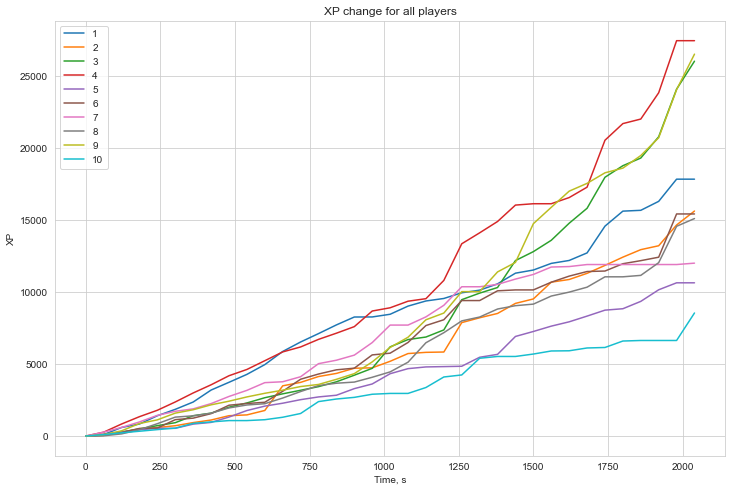

In [ ]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [ ]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [ ]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        lh = 0
        count = 1
        for player in match["players"]:
            df_features.loc[match_id_hash, "$countlh"] = lh

In [ ]:
match['players'][5]

{'player_slot': 128,
 'hero_id': 52,
 'hero_name': 'npc_dota_hero_leshrac',
 'account_id_hash': '590fc6f3c8065748e65481a70f632248',
 'ability_upgrades': [{'ability': 5243, 'time': 379, 'level': 1},
  {'ability': 5241, 'time': 460, 'level': 2},
  {'ability': 5243, 'time': 628, 'level': 3},
  {'ability': 5241, 'time': 650, 'level': 4},
  {'ability': 5243, 'time': 789, 'level': 5},
  {'ability': 5244, 'time': 913, 'level': 6},
  {'ability': 5243, 'time': 1025, 'level': 7},
  {'ability': 5242, 'time': 1074, 'level': 8},
  {'ability': 5242, 'time': 1107, 'level': 9},
  {'ability': 5242, 'time': 1307, 'level': 10},
  {'ability': 5242, 'time': 1397, 'level': 11},
  {'ability': 5244, 'time': 1464, 'level': 12},
  {'ability': 5241, 'time': 1484, 'level': 13},
  {'ability': 5241, 'time': 1596, 'level': 14},
  {'ability': 5932, 'time': 1758, 'level': 15},
  {'ability': 6145, 'time': 2045, 'level': 16}],
 'obs_placed': 1,
 'sen_placed': 0,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups'

In [ ]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [ ]:
(df_train_features.columns == "lh").sum()

0

In [ ]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [ ]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 157 ms, sys: 369 ms, total: 525 ms
Wall time: 2min 8s


In [ ]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!